In [22]:
# Import necessary libraries
import torch
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [23]:
# Load knowledge graph triples and concept attribute collocations with labels
data = pd.read_excel('C:/Users/sanmeet/Documents/4th_Year/4th_Year_Sem2/BTech_Project/code/knowledge_graph_triples_complete.xls')
print(data)

        Target       Attribute                    Source  labels
0         face           black                      coal       1
1        uncle           blind                       bat       1
2        naina            cool                  cucumber       1
3      soldier           brave                      lion       1
4           he         cunning                       fox       1
...        ...             ...                       ...     ...
1810  Computer         Stylish              Sleek Design       0
1811     Chair         Stylish      Decorative Stitching       0
1812     Movie        Animated             Cartoon Style       0
1813    Person            Kind       Empathetic Attitude       0
1814   Vehicle  Fuel-efficient  Hybrid Engine Technology       0

[1815 rows x 4 columns]


In [24]:
# Split the data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

In [25]:
# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [26]:
# Define a function to encode the text into BERT embeddings
def get_embeddings(text):
  inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
  outputs = model(**inputs)
  embeddings = outputs.last_hidden_state.mean(dim=1).squeeze()
  return embeddings.detach().numpy()

In [27]:
# print(train_data['Target'])

# Encode the target, attribute, and source columns into BERT embeddings
train_embeddings = np.concatenate([get_embeddings(list(train_data['Target'])), 
                                   get_embeddings(list(train_data['Attribute'])), 
                                   get_embeddings(list(train_data['Source']))], axis=1)
test_embeddings = np.concatenate([get_embeddings(list(test_data['Target'])), 
                                  get_embeddings(list(test_data['Attribute'])), 
                                  get_embeddings(list(test_data['Source']))], axis=1)

In [35]:
print(train_embeddings)

[[-0.18574706 -0.03012958 -0.19486105 ...  0.08866606  0.03762847
   0.17091021]
 [-0.2907276  -0.34988308 -0.03953591 ... -0.00091708 -0.13026695
  -0.25560746]
 [ 0.24223495 -0.1106503   0.11134851 ... -0.01663986 -0.07298139
   0.07672381]
 ...
 [-0.32128778  0.21084636 -0.3163085  ...  0.27484092 -0.00340685
   0.06075066]
 [-0.00328109  0.12295499 -0.17521341 ...  0.15165162  0.00636819
   0.00513058]
 [ 0.03335669 -0.13680516  0.09875403 ...  0.08146471  0.02225824
   0.02497298]]


In [36]:
# Define the model
clf = torch.nn.Linear(train_embeddings.shape[1], 2)

In [38]:
# Train the model
optimizer = torch.optim.Adam(clf.parameters())
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 10
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = clf(torch.tensor(train_embeddings).float())
    loss = criterion(outputs, torch.tensor(train_data['labels']).long())
    loss.backward()
    optimizer.step()

In [70]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

In [71]:
# Evaluate the model
predictions = clf(torch.tensor(test_embeddings).float()).argmax(dim=1)

In [72]:
# Accuracy
accuracy = accuracy_score(test_data['labels'], predictions)
print("Accuracy:", accuracy)

Accuracy: 0.9504132231404959


In [73]:
# Calculate precision, recall, and F1 score
precision = precision_score(test_data['labels'], predictions)
recall = recall_score(test_data['labels'], predictions)
f1 = f1_score(test_data['labels'], predictions)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.9475308641975309
Recall: 0.9967532467532467
F1 Score: 0.9715189873417721


In [74]:
confusion = confusion_matrix(test_data['labels'], predictions)

print("Confusion Matrix:\n", confusion)

Confusion Matrix:
 [[ 38  17]
 [  1 307]]


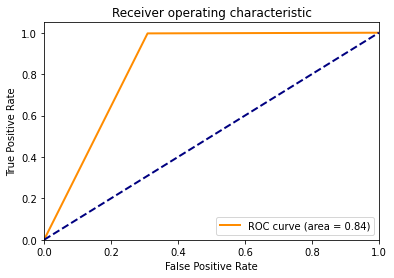

<Figure size 432x288 with 0 Axes>

In [75]:
# Calculate ROC curve and AUC score

fpr, tpr, _ = roc_curve(test_data['labels'], predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
plt.savefig('roc.png')